# Week6 과제 

- 서울시 열린데이터 https://data.seoul.go.kr/ 에서 제공하는 서울특별시_공공자전거 일별 대여건수_(2018~2019.03).csv를 분석해보자. 파일은 웹 검색을 해서 다운로드해서 사용하면 된다. 데이터는 일자별로, 대여건수이이고, 몇 줄만 출력해보면 다음과 같다.

In [1]:
import pyspark

spark = pyspark.sql.SparkSession\
    .builder\
    .master('local')\
    .appName('week6_assignment')\
    .config(conf=pyspark.SparkConf())\
    .getOrCreate()

21/10/09 17:39:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/10/09 17:39:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
from pyspark.sql.functions import split

colName = ["Date", "Count"]
bicycleDf = spark.read\
.options(header="true", inferschema='true').csv("data/publicBicycle_daily_rental_2018_2019_03.csv")

bicycleDf = bicycleDf.withColumnRenamed(bicycleDf.columns[0], "Date")
bicycleDf = bicycleDf.withColumnRenamed(bicycleDf.columns[1], "Count")
print(bicycleDf.printSchema())
print(f"Total num of data: {bicycleDf.count()}")


root
 |-- Date: string (nullable = true)
 |-- Count: integer (nullable = true)

None
Total num of data: 455


In [3]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, DateType

bicycleDf = bicycleDf.withColumn("Year", F.year(bicycleDf["Date"]))
bicycleDf = bicycleDf.withColumn("Month", F.month(bicycleDf["Date"]))
bicycleDf = bicycleDf.withColumn("Quarter", F.quarter(bicycleDf["Date"]))
bicycleDf.show(5)

+----------+-----+----+-----+-------+
|      Date|Count|Year|Month|Quarter|
+----------+-----+----+-----+-------+
|2018-01-01| 4950|2018|    1|      1|
|2018-01-02| 7136|2018|    1|      1|
|2018-01-03| 7156|2018|    1|      1|
|2018-01-04| 7102|2018|    1|      1|
|2018-01-05| 7705|2018|    1|      1|
+----------+-----+----+-----+-------+
only showing top 5 rows



### 문제 1-1 년도별 대여건수 합계

In [4]:
bicycleDf.groupBy("Year").sum().select("Year", "sum(Count)").show()

+----+----------+
|Year|sum(Count)|
+----+----------+
|2018|  10124874|
|2019|   1871935|
+----+----------+



### 문제 1-2 년도별, 월별 대여건수 합계

In [5]:
_bicycleDf = bicycleDf.groupBy("Year", "Month").sum().select("Year", "Month", "sum(Count)").sort("Year", "Month")
_bicycleDf = _bicycleDf.withColumnRenamed('sum(Count)', 'Count')
bicycleDf = _bicycleDf.groupBy("Month").pivot("Year").agg(F.sum("Count")).orderBy('Month')

bicycleDf.show()

+-----+-------+------+
|Month|   2018|  2019|
+-----+-------+------+
|    1| 164367|495573|
|    2| 168741|471543|
|    3| 462661|904819|
|    4| 687885|  null|
|    5| 965609|  null|
|    6|1207123|  null|
|    7|1100015|  null|
|    8|1037505|  null|
|    9|1447993|  null|
|   10|1420621|  null|
|   11| 961532|  null|
|   12| 500822|  null|
+-----+-------+------+



### 문제 1-3 문제 1-2의 출력을 선 그래프로 그려보자.

<AxesSubplot:xlabel='Month'>

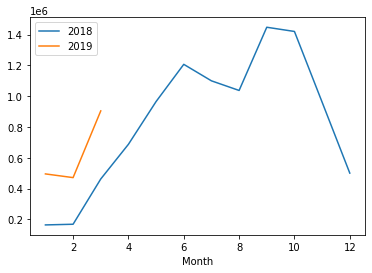

In [17]:
import pandas as pd

bicycleP = bicycleDf.toPandas()
bicycleP = bicycleP.set_index("Month")
bicycleP.plot(kind='line')